<a href="#measuring-churn-rate">Measuring Churn Rate</a>
- <a href="#standard-based-churn-rate">Standard Churn Rate (Subscription)</a>
- <a href="#activity-based-churn-rate">Activity Churn Rate (Non-Subscription)</a>

<a href="#measuring-customers">Measuring Customers</a>
- <a href="#common-summay-metrics">Common Summary Metrics (Count, Total, Avg, etc)</a>
- <a href="#account-tenure">Account Tenure Metrics</a>

<a href="#observing-churn">Observing Churn</a>
- <a href="#observation-datetime-picking">Observation Datetime Picking and Outcome</a>
- <a href="#analytic-data">Features (Metrics) for each observation instance. Analytic summary data</a>

In [1786]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math
import matplotlib.pyplot as plt


In [1084]:
df = pd.read_json('data/mini_sparkify_event_data.json', orient='records', lines=True)
df.head(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [1085]:
df = df.drop(np.where(df.userId == '')[0])
df.head(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [1086]:
# Convert User Id to numeric type
df.userId = df.userId.astype('int')

# Drop 'useless' attributes
df = df.drop(['registration', 'userAgent', 'status', 'method', ], axis=1)
df.head(10)

# Join First Name and Last Name to Fullname column, then drop First Name, Last Name
df['fullname'] = df['firstName'] + ' ' + df['lastName']
df = df.drop(['firstName', 'lastName'], axis=1)

In [1087]:
# Create 'datetime' column, based on timpstamp value, convert UTC time.
# Convert type to pandas datetime type

df['datetime'] = df['ts'].apply(lambda x: datetime.utcfromtimestamp(x/1000).isoformat())
df['datetime'] = df['datetime'].astype('datetime64[ns]')

df['date'] = df.ts.apply(lambda x: datetime.utcfromtimestamp(x/1000).isoformat()[:10])

In [1088]:
# Check earlist date and latest date in the dataset

print(np.min(df['datetime']))
print(np.max(df['datetime']))

2018-10-01 00:01:57
2018-12-03 01:11:16


In [1089]:
# Date range in the dataset
np.max(df['datetime']) - np.min(df['datetime'])

Timedelta('63 days 01:09:19')

In [1090]:
# Helper Function. get timedelta
# Get a user's timerange of event. (delta of earlist event date to latest event date)

def get_timedelta_by_user(user_id, data=df):
    min_datetime = np.min(data[data.userId == user_id]['datetime'])
    max_datetime = np.max(data[data.userId == user_id]['datetime'])
    d = max_datetime - min_datetime
    return d

# Spot Check
get_timedelta_by_user(152)

Timedelta('31 days 17:01:23')

In [1091]:
# Spot Check: Cancellation Event Count
df[(df.page == 'Cancel') | (df.page == 'Cancellation Confirmation')]['page'].value_counts()

Cancel                       52
Cancellation Confirmation    52
Name: page, dtype: int64

In [1092]:
# Spot Check: Cancellation Event Count (string method)
df[(df.page.str.startswith('Cancel'))]['page'].value_counts()

Cancel                       52
Cancellation Confirmation    52
Name: page, dtype: int64

In [1093]:
# Number of event records
print(df.shape[0])

# Number of distinct users
print(df.userId.nunique())

278154
225


In [1094]:
# Number of 'authentication' values check

df['auth'].value_counts()

Logged In    278102
Cancelled        52
Name: auth, dtype: int64

---

<a id="measuring-churn-rate"></a>

## Measuring Churn Rate

---

observation date recall that follow weekly cycles, so pick a last sunday (or monday 0:00) date as end day

In [1095]:
# Set the observation timeframe we want to do churn model.
# 4 Weeks. 

observation_end_date = pd.Timestamp('2018-12-03') # 49th Monday of 2018.
observation_start_date = observation_end_date - pd.Timedelta("28 days") # 45th Monday of 2018

In [1096]:
def check_last_event(ids, data=df):
    # Check the last event for a list of users.
    
    # return (page, auth, level, time)
    
    l = []
    
    for i in ids:
        page = data[data.userId == i].tail(1).page.values[0]
        auth = data[data.userId == i].tail(1).auth.values[0]
        level = data[data.userId == i].tail(1).level.values[0]
        dt = pd.Timestamp(data[data.userId == i].tail(1).datetime.values[0])
        
        l.append((i, page, auth, level, dt))
        
    return l


---
<a id="standard-based-churn-rate"></a>

### Standard account-basd churn rate

Glance of churn rate for 2018 Nov full calendar.

Since the limitation of event data, we dont have access to Subscription database (information such as sub id, renew date, therefore, to utilize the event data, we calculate the standard account-based churn rate (for Nov 2018) as:

Number of users whose first event is a paid status last event is also a paid status and not cancel auth
/
Total distinct number of users in the month




In [1097]:
# Define 2018 Nov start and end dates
nov_start_date = '2018-11-01T00:00:00'
nov_end_date = '2018-12-01T00:00:00'

# 2018 Nov Data Frame
df_nov = df[(df.datetime > nov_start_date) & (df.datetime < nov_end_date)]

# Distinct user ids in Nov 2018
nov_uids = df_nov.userId.value_counts().index 

# Numbers of user ids in Nov 2018
n_nov_uids = len(nov_uids) 

In [1098]:
# The VERY FIRST event for each user in Nov 2018
df_nov_first = df_nov.drop_duplicates('userId', keep='first').\
sort_values('userId')[['userId', 'auth', 'level', 'datetime']]

df_nov_first = df_nov_first.set_index('userId')

In [1099]:
# Users that first event in Nov 2018 is under 'paid' status. (Subscriber already)
df_nov_starts_with_paid = df_nov_first[df_nov_first['level'] == 'paid']
df_nov_starts_with_paid

,auth,level,datetime
userId,,,
2,Logged In,paid,2018-11-02 14:49:33
4,Logged In,paid,2018-11-04 13:23:21
6,Logged In,paid,2018-11-01 06:40:13
9,Logged In,paid,2018-11-01 01:49:01
10,Logged In,paid,2018-11-03 14:27:42
...,...,...,...
300020,Logged In,paid,2018-11-13 12:06:12
300021,Logged In,paid,2018-11-01 13:10:20
300022,Logged In,paid,2018-11-05 01:08:50


In [1100]:
# The VERY LAST event for each user in Nov 2018

df_nov_last = df_nov.drop_duplicates('userId', keep='last').\
sort_values('userId')[['userId', 'auth', 'level', 'datetime']]

df_nov_last = df_nov_last.set_index('userId')
df_nov_last.head(10)

,auth,level,datetime
userId,,,
2,Logged In,paid,2018-11-21 22:30:04
4,Logged In,paid,2018-11-30 16:32:28
5,Logged In,free,2018-11-08 00:33:21
6,Logged In,paid,2018-11-29 22:48:26
7,Logged In,free,2018-11-23 06:46:51
8,Logged In,free,2018-11-30 13:54:57
9,Logged In,paid,2018-11-30 14:19:12
10,Logged In,paid,2018-11-19 12:49:48
11,Logged In,paid,2018-11-27 09:08:22


In [1101]:
# Merger userFirst and userLast. Then check who churn under condition: 
# 1 - if begin with paid, end with free. (cancelled before the very last), OR
# 2 - if begin with paid, end with paid but it is ALSO the last paid event (cancel is the last event)

df_nov_first_last = pd.merge(df_nov_first, df_nov_last, how='inner', on='userId')

df_nov_churn = df_nov_first_last[
    ((df_nov_first_last.level_x == 'paid') & (df_nov_first_last.level_y == 'free')) | 
    ((df_nov_first_last.level_x == 'paid') & (df_nov_first_last.auth_y == 'Cancelled'))
]

df_nov_churn

,auth_x,level_x,datetime_x,auth_y,level_y,datetime_y
userId,,,,,,
28,Logged In,paid,2018-11-01 00:00:06,Cancelled,paid,2018-11-06 00:20:32
29,Logged In,paid,2018-11-01 00:03:11,Cancelled,paid,2018-11-14 07:37:11
35,Logged In,paid,2018-11-01 05:23:02,Logged In,free,2018-11-30 10:24:09
53,Logged In,paid,2018-11-04 00:20:10,Cancelled,paid,2018-11-19 12:34:56
54,Logged In,paid,2018-11-01 00:02:21,Cancelled,paid,2018-11-12 19:40:08
70,Logged In,paid,2018-11-02 01:20:40,Cancelled,paid,2018-11-14 22:34:27
92,Logged In,paid,2018-11-01 05:09:45,Logged In,free,2018-11-30 23:34:25
103,Logged In,paid,2018-11-03 08:27:37,Cancelled,paid,2018-11-04 14:01:31
106,Logged In,paid,2018-11-02 13:07:17,Cancelled,paid,2018-11-02 13:47:04


In [1102]:
# Calculate Nov 2018 Churn Rate based on Standard account-based (paid-status or cancellation event)

print(f"Number of customers at the start of nov: {df_nov_starts_with_paid.shape[0]}")
print(f"Number of customers at the end of nov: {df_nov_churn.shape[0]}")

nov_churn_rate = df_nov_churn.shape[0] / df_nov_starts_with_paid.shape[0]

print(f"2018 Nov churn rate: {nov_churn_rate}")
print(f"2018 Nov retention rate: {1 - nov_churn_rate}")

Number of customers at the start of nov: 102
Number of customers at the end of nov: 21
2018 Nov churn rate: 0.20588235294117646
2018 Nov retention rate: 0.7941176470588236


---
<a id="activity-based-churn-rate"></a>
### Activity Based Churn for non-subscriber

In addtion to standard churn rate calculation, I would also calculate churn rate for non-paid ('free') user, based on activity
 measure for Nov 2018.
 
We can obtain an overview of the engagement, utilization of free user. 

How many of free user discontine to use the free service. 

Based on activity recency. Define an inactive time interval, eg 1 month.
Short gaps can be ignore



1. Observe on the start day. (Nov 1), get all free uses have activities within oct 1 - nov 1. Get the head count. 
2. Observe on the end day. (Before Dec 1), get all users have activities within nov 1 - dec 1. Get the head count. 
3. Calculation: End head count / Start head count  (Retaintion Rate)
4. Churn Rate + Retaintion Rate = 1

In [1103]:
# Two observations: 
# 1. Observation on start date of the month 
# 2. Observation on end date of the month
# Recency interval: 30 days

nov_start_date = '2018-11-01T00:00:00'
nov_end_date = '2018-12-01T00:00:00'
recency_interval = '30 days'

# Convert to pd timestamp type
free_nov_ob_start_date = pd.Timestamp(nov_start_date)
free_nov_ob_end_date = pd.Timestamp(nov_end_date)

# Calcuate the inactivity limit for start and end
recency_start_date = free_nov_ob_start_date - pd.Timedelta(recency_interval)
recency_end_date = free_nov_ob_end_date - pd.Timedelta(recency_interval)

print(recency_start_date)
print(recency_end_date)

2018-10-02 00:00:00
2018-11-01 00:00:00


In [1104]:
# Free users count at the start

free_start_count = df[
    (df.datetime >= recency_start_date) & 
    (df.datetime < recency_end_date) & 
    (df.level == 'free')
].groupby('userId').size().shape[0]

free_start_count

173

In [1105]:
# Free users count at the end

free_end_count = df[
    (df.datetime >= recency_end_date) & 
    (df.datetime < nov_end_date) & 
    (df.level == 'free')
].groupby('userId').size().shape[0]

free_end_count # retain

103

In [1106]:
print(f"Number of free users churn for 2018 Nov (Based on activity recency): {free_start_count - free_end_count}")

print(f"Free Users Churn Rate for 2018 Nov (Based on activity recency): \
{(free_start_count - free_end_count) / free_start_count}")

print(f"Free Users Retain Rate for 2018 Nov (Based on activity recency): \
{free_end_count / free_start_count}")

Number of free users churn for 2018 Nov (Based on activity recency): 70
Free Users Churn Rate for 2018 Nov (Based on activity recency): 0.4046242774566474
Free Users Retain Rate for 2018 Nov (Based on activity recency): 0.5953757225433526


---

<a id="measuring-customers"></a>

## Measuring Customers (Feature Engineering)


- Measuring counts, averages, and totals of customer events 
- Measuring how long a customer has been using a service 
- Measuring subscription metrics

---

In [1107]:
# The measuring metrics based on this timeframe (4 weeks)

print(observation_start_date)  # 45th Monday of 2018
print(observation_end_date)  # 49th Monday of 2018.

# 4 weeks in between
observation_end_date - observation_start_date

2018-11-05 00:00:00
2018-12-03 00:00:00


Timedelta('28 days 00:00:00')

In [1108]:
# Softcopy for periods subset to work on.

df_p = df.copy()
df_p.head()

,ts,userId,sessionId,page,auth,level,itemInSession,location,gender,artist,song,length,fullname,datetime,date
0,1538352117000,30,29,NextSong,Logged In,paid,50,"Bakersfield, CA",M,Martha Tilston,Rockpools,277.89016,Colin Freeman,2018-10-01 00:01:57,2018-10-01
1,1538352180000,9,8,NextSong,Logged In,free,79,"Boston-Cambridge-Newton, MA-NH",M,Five Iron Frenzy,Canada,236.09424,Micah Long,2018-10-01 00:03:00,2018-10-01
2,1538352394000,30,29,NextSong,Logged In,paid,51,"Bakersfield, CA",M,Adam Lambert,Time For Miracles,282.82730,Colin Freeman,2018-10-01 00:06:34,2018-10-01
3,1538352416000,9,8,NextSong,Logged In,free,80,"Boston-Cambridge-Newton, MA-NH",M,Enigma,Knocking On Forbidden Doors,262.71302,Micah Long,2018-10-01 00:06:56,2018-10-01
4,1538352676000,30,29,NextSong,Logged In,paid,52,"Bakersfield, CA",M,Daft Punk,Harder Better Faster Stronger,223.60771,Colin Freeman,2018-10-01 00:11:16,2018-10-01


In [1109]:
# Utility Function: Assign period number. 

def period_from_datetime(x):
    """
    Assign each log a period number based on date. 
    Default 0.
    '4' is actually the latest 4 full weeks (28 days).
    `period 3` is 7-days before `period 4`. (28 days).
    `period 2` is 7-days before `period 3`. (28 days).
    `period 1` is 7-days before `period 2`. (28 days).
    
    Each period is 28 days, moving 7 days ahead from its previous period. 
    (moving 7 days)
    """
    period = 0 # default 0: out of window concerned. to filter out.
    
    if (x >= pd.Timestamp('2018-10-15')) & (x < pd.Timestamp('2018-11-12')): 
        period = 1
    
    if (x >= pd.Timestamp('2018-10-22')) & (x < pd.Timestamp('2018-11-19')):
        period = 2
    
    if (x >= pd.Timestamp('2018-10-29')) & (x < pd.Timestamp('2018-11-26')):
        period = 3
        
    if (x >= pd.Timestamp('2018-11-05')) & (x < pd.Timestamp('2018-12-03')):
        period = 4
        
    return period


# df_p[-20:]['datetime'].apply(period_from_datetime)

In [1110]:
# Add a column of period, assign each event to a period base on its datetime.

df_p['period'] = df_p['datetime'].apply(period_from_datetime)

In [1111]:
# p1,2,3,4 is what we concern. 0 is out of timeframe we don't consider. 

df_p[df_p.period.isin([1,2,3,4])].head(5)

,ts,userId,sessionId,page,auth,level,itemInSession,location,gender,artist,song,length,fullname,datetime,date,period
43747,1539561613000,133,167,Home,Logged In,free,0,"San Diego-Carlsbad, CA",M,NaN,NaN,NaN,Liam Fleming,2018-10-15 00:00:13,2018-10-15,1
43748,1539561620000,9,583,NextSong,Logged In,paid,96,"Boston-Cambridge-Newton, MA-NH",M,Edward Sharpe & The Magnetic Zeros,Up From Below,250.27873,Micah Long,2018-10-15 00:00:20,2018-10-15,1
43749,1539561692000,133,167,NextSong,Logged In,free,1,"San Diego-Carlsbad, CA",M,Starflyer 59,When You Feel The Mess,376.86812,Liam Fleming,2018-10-15 00:01:32,2018-10-15,1
43750,1539561762000,54,782,NextSong,Logged In,paid,243,"Spokane-Spokane Valley, WA",F,Aphex Twin,Xtal,294.05995,Alexi Warren,2018-10-15 00:02:42,2018-10-15,1
43751,1539561778000,61,766,NextSong,Logged In,free,18,"San Francisco-Oakland-Hayward, CA",M,Ludovico Einaudi,Nefeli,266.94485,Parker Williams,2018-10-15 00:02:58,2018-10-15,1


In [1112]:
# Spot Check: Distinct Events

df['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Name: page, dtype: int64

<a id="common-summay-metrics"></a>
### Common Summary Metrics

e.g Count, Total, Avg, Sum

In [1113]:
# Summary df for n_like within 4 moving period, each period is 4 weeks

df_n_like = df_p[df_p.period.isin([1,2,3,4])]
df_n_like = df_n_like[df_n_like.page == 'Thumbs Up']
ds_like_count = df_n_like.groupby(['userId', 'period'])['page'].count()

# turn groupby output to dataframe
df_n_like_count = pd.DataFrame(ds_like_count).reset_index()
df_n_like_count.columns = ['userId', 'period', 'n_like']
df_n_like_count.head(10)

,userId,period,n_like
0,2,2,1
1,2,3,3
2,2,4,8
3,3,2,10
4,3,3,3
5,4,1,5
6,4,2,12
7,4,3,25
8,4,4,53
9,5,2,5


In [1114]:
# Summary df for n_songplay within 4 moving period, each period is 4 weeks

df_n_play = df_p[df_p.period.isin([1,2,3,4])]
df_n_play = df_n_play[df_n_play.page == 'NextSong']
ds_nplay_count = df_n_play.groupby(['userId', 'period'])['page'].count()

# turn groupby output to dataframe
df_n_play_count = pd.DataFrame(ds_nplay_count).reset_index()
df_n_play_count.columns = ['userId', 'period', 'n_songplay']
df_n_play_count.head(10)

,userId,period,n_songplay
0,2,2,50
1,2,3,99
2,2,4,247
3,3,2,154
4,3,3,38
5,4,1,102
6,4,2,315
7,4,3,576
8,4,4,1025
9,5,2,78


In [1115]:
# Summary df for n_displike within 4 moving period, each period is 4 weeks

df_n_dislike = df_p[df_p.period.isin([1,2,3,4])]
df_n_dislike = df_n_dislike[df_n_dislike.page == 'Thumbs Down']
ds_ndislike_count = df_n_dislike.groupby(['userId', 'period'])['page'].count()

# turn groupby output to dataframe
df_n_dislike_count = pd.DataFrame(ds_ndislike_count).reset_index()
df_n_dislike_count.columns = ['userId', 'period', 'n_dislike']
df_n_dislike_count.head(10)

,userId,period,n_dislike
0,2,4,3
1,3,2,3
2,4,1,4
3,4,2,1
4,4,3,10
5,4,4,11
6,6,1,2
7,6,2,4
8,6,3,10
9,6,4,11


In [1116]:
# Summary df for n_addplaylist within 4 moving period, each period is 4 weeks

df_n_addplaylist = df_p[df_p.period.isin([1,2,3,4])]
df_n_addplaylist = df_n_addplaylist[df_n_addplaylist.page == 'Add to Playlist']
ds_n_addplaylist = df_n_addplaylist.groupby(['userId', 'period'])['page'].count()

# turn groupby output to dataframe
df_n_addplaylist_count = pd.DataFrame(ds_n_addplaylist).reset_index()
df_n_addplaylist_count.columns = ['userId', 'period', 'n_addplaylist']
df_n_addplaylist_count.head(10)

,userId,period,n_addplaylist
0,2,3,1
1,2,4,7
2,3,2,3
3,3,3,1
4,4,1,4
5,4,2,7
6,4,3,13
7,4,4,35
8,5,2,4
9,5,4,2


In [1117]:
# Summary df for n_addfriend within 4 moving period, each period is 4 weeks

df_n_addfriend = df_p[df_p.period.isin([1,2,3,4])]
df_n_addfriend = df_n_addfriend[df_n_addfriend.page == 'Add Friend']
ds_n_addfriend = df_n_addfriend.groupby(['userId', 'period'])['page'].count()

# turn groupby output to dataframe
df_n_addfriend_count = pd.DataFrame(ds_n_addfriend).reset_index()
df_n_addfriend_count.columns = ['userId', 'period', 'n_addfriend']
df_n_addfriend_count.head(10)

,userId,period,n_addfriend
0,2,2,2
1,2,3,4
2,2,4,7
3,3,2,1
4,4,2,6
5,4,3,12
6,4,4,27
7,5,2,2
8,5,4,1
9,6,1,1


In [1118]:
# Summary df for n_adview within 4 moving period, each period is 4 weeks

df_n_adview = df_p[df_p.period.isin([1,2,3,4])]
df_n_adview = df_n_adview[df_n_adview.page == 'Roll Advert']
ds_n_adview = df_n_adview.groupby(['userId', 'period'])['page'].count()

# turn groupby output to dataframe
df_n_adview_count = pd.DataFrame(ds_n_adview).reset_index()
df_n_adview_count.columns = ['userId', 'period', 'n_adview']
df_n_adview_count.head(10)

,userId,period,n_adview
0,3,3,1
1,4,1,4
2,5,2,4
3,5,4,3
4,6,1,1
5,6,2,1
6,6,3,1
7,6,4,2
8,7,1,2
9,7,2,9


In [1119]:
# Summary df for n_session within 4 moving period, each period is 4 weeks

df_n_session = df_p[df_p.period.isin([1,2,3,4])]

df_n_session = \
pd.DataFrame(df_n_session.groupby(['userId', 'period', 'sessionId']).size()).reset_index().drop([0], axis=1)

df_n_session_count = pd.DataFrame(df_n_session.groupby(['userId','period'])['sessionId'].count()).reset_index()
df_n_session_count.columns = ['userId', 'period', 'n_session']
df_n_session_count


,userId,period,n_session
0,2,2,1
1,2,3,2
2,2,4,3
3,3,2,2
4,3,3,1
...,...,...,...
612,300024,1,1
613,300025,1,2
614,300025,2,3
615,300025,3,1


In [1120]:
# Summary df for n_itemsession within 4 moving period, each period is 4 weeks
# Total items in all sessions per period per user (represents usage, shoule be corelated to song play)

ds_n_itemsession = pd.DataFrame(
    df_p[df_p.period.isin([1,2,3,4])].groupby(['userId', 'period','sessionId'])['itemInSession'].count()
).reset_index().groupby(['userId', 'period'])['itemInSession'].sum()

df_n_itemsession_count = pd.DataFrame(ds_n_itemsession).reset_index()
df_n_itemsession_count.columns = ['userId', 'period', 'n_itemsession']

df_n_itemsession_count 


,userId,period,n_itemsession
0,2,2,55
1,2,3,118
2,2,4,298
3,3,2,183
4,3,3,47
...,...,...,...
612,300024,1,102
613,300025,1,42
614,300025,2,139
615,300025,3,185


In [1121]:
# Summary. Sessions Count, Session Items Count, Items per session each period. 

df_session_summary = pd.merge(df_n_session_count, df_n_itemsession_count)
df_session_summary['items_per_session'] = df_session_summary['n_itemsession'] / df_session_summary['n_session']
df_session_summary

,userId,period,n_session,n_itemsession,items_per_session
0,2,2,1,55,55.000000
1,2,3,2,118,59.000000
2,2,4,3,298,99.333333
3,3,2,2,183,91.500000
4,3,3,1,47,47.000000
...,...,...,...,...,...
612,300024,1,1,102,102.000000
613,300025,1,2,42,21.000000
614,300025,2,3,139,46.333333
615,300025,3,1,185,185.000000


In [1122]:
# Summary. Total listen duration for each user per period. 

df_duration = df_p[(df_p['page'] == 'NextSong') & df_p.period.isin([1,2,3,4])][['userId', 'period', 'length']]

df_duration_total = pd.DataFrame(
    df_duration.groupby(['userId', 'period'])['length'].sum()
).reset_index()

df_duration_total.columns = ['userId', 'period', 'total_duration']
df_duration_total


,userId,period,total_duration
0,2,2,11945.95611
1,2,3,23915.42291
2,2,4,62124.84475
3,3,2,38639.29017
4,3,3,10421.45543
...,...,...,...
611,300024,1,22698.64417
612,300025,1,7703.44387
613,300025,2,27444.63957
614,300025,3,39919.26219


In [1123]:
# Summary. Playback duration per session.

df_duration_m = \
df_p[(df_p['page'] == 'NextSong') & df_p.period.isin([1,2,3,4])][['userId','period','sessionId','length']]

df_duration_n_ses = pd.DataFrame(
    pd.DataFrame(
        df_duration_m.groupby(['userId', 'period', 'sessionId'])['length'].sum()
    ).reset_index()\
        .groupby(['userId', 'period'])['sessionId'].size()
        ).reset_index()

df_duration_total = pd.DataFrame(
    df_duration_m.groupby(['userId', 'period'])['length'].sum()
).reset_index()

df_duration_summary = pd.merge(df_duration_n_ses, df_duration_total)
df_duration_summary['avg_play_duration'] = df_duration_summary['length'] / df_duration_summary['sessionId']
df_duration_summary.columns = ['userId','period','n_play_session', 'total_playback_duration', 'avg_playback_duration']
df_duration_summary


,userId,period,n_play_session,total_playback_duration,avg_playback_duration
0,2,2,1,11945.95611,11945.956110
1,2,3,2,23915.42291,11957.711455
2,2,4,3,62124.84475,20708.281583
3,3,2,2,38639.29017,19319.645085
4,3,3,1,10421.45543,10421.455430
...,...,...,...,...,...
611,300024,1,1,22698.64417,22698.644170
612,300025,1,2,7703.44387,3851.721935
613,300025,2,3,27444.63957,9148.213190
614,300025,3,1,39919.26219,39919.262190


<a id="account-tenure"></a>
### Account Tenure

tenure should measure only the current subscription.



In [1124]:
user4 = df[df.userId == 4]

In [1125]:
np.where(user4.groupby('level').cumcount() == 0)

(array([  0, 141]),)

In [1126]:
# experiment cumcount() shift()
# https://stackoverflow.com/questions/25119524/pandas-conditional-rolling-count

dft = pd.DataFrame({
    'x': [1,2,3,4,5,6,7,8,9,10,11],
    'y': ['a','a', 'a', 'b', 'b','b','b','b','a','a','a']
})

dft.groupby(
    (dft['y'] != dft['y'].shift(1)).cumsum()
).cumcount()

0     0
1     1
2     2
3     0
4     1
5     2
6     3
7     4
8     0
9     1
10    2
dtype: int64

In [1127]:
# Experiment on Tenure calculation with User ID 4

user4['cumcount'] = user4.groupby(
    (user4['level'] != user4['level'].shift(1)).cumsum()
).cumcount()



/var/folders/z2/4x1xtsmd40sfmyp2ftrfbkfh0000gn/T/ipykernel_25639/1498505545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user4['cumcount'] = user4.groupby(


In [1128]:
user4[['level', 'cumcount', 'datetime']]

# Start Date of latest subscription
user4[(user4.cumcount == 0) & (user4.level == 'paid')].tail(1).iloc[0].datetime

# End Date of latest subscription
user4[
    (user4.level == 'paid') & (~user4.page.str.startswith('Cancel'))
].tail(1).iloc[0].datetime

# Tenure Days
(user4[
    (user4.level == 'paid') & (~user4.page.str.startswith('Cancel'))
].tail(1).iloc[0].datetime) - (user4[(user4.cumcount == 0) & (user4.level == 'paid')].tail(1).iloc[0].datetime)

Timedelta('40 days 05:03:25')

In [1129]:
# Users in Observation timeframe [Timestamp('2018-11-05 00:00:00') to Timestamp('2018-12-03 00:00:00')]
# that also have 'paid' status. (subscriber)
# These are the users we concern currently.

uids_obs = list(df_p[
        (df_p.period == 4) & 
        (df_p.level == 'paid')
    ].groupby('userId').size().index)

len(uids_obs)

132

In [1310]:
# Utility Function. Get tunure days
def get_tenures(ids=uids_obs):
     
    """
    Get user's tenure days.
    Key value pair.
    
    Input: list of user ids. Assuming that argument ids are paid user. 
    Output: dict of key value pairs. key: user, value: tunure
    """
    
    dfsub = df[df.datetime < observation_end_date]
    
    tenures = {}
    
    for i in ids:
        dfu = dfsub[dfsub.userId == i]
        
        # Make a cumulative count column
        dfu['cumcount'] = dfu.groupby(
            (dfu['level'] != dfu['level'].shift(1)).cumsum()
        ).cumcount()
        
        # Start Date of latest subscription
        start = dfu[(dfu.cumcount == 0) & (dfu.level == 'paid')].tail(1).iloc[0].datetime
        start_date = str(start)[:10]
        
        # End Date of latest subscription
        end = dfu[
            (dfu.level == 'paid') & (~dfu.page.str.startswith('Cancel'))
        ].tail(1).iloc[0].datetime
        end_date = str(end)[:10]
        
        diff = pd.Timestamp(end_date) - pd.Timestamp(start_date)
#         print(diff.days)
        
        
        # append result, first day starts with 0
        tenures[i] = diff.days
        
    return tenures

tenures = get_tenures()
tenures

/var/folders/z2/4x1xtsmd40sfmyp2ftrfbkfh0000gn/T/ipykernel_25639/1874448288.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfu['cumcount'] = dfu.groupby(


{2: 44,
 4: 40,
 6: 54,
 9: 30,
 10: 42,
 11: 11,
 13: 0,
 14: 49,
 15: 55,
 16: 57,
 20: 10,
 21: 34,
 23: 2,
 25: 10,
 26: 0,
 28: 8,
 29: 37,
 30: 2,
 33: 57,
 35: 13,
 36: 17,
 37: 43,
 38: 37,
 39: 0,
 40: 30,
 41: 51,
 42: 54,
 45: 39,
 46: 29,
 49: 0,
 50: 9,
 52: 26,
 53: 26,
 54: 14,
 55: 0,
 56: 22,
 59: 24,
 60: 46,
 61: 26,
 62: 50,
 65: 53,
 66: 35,
 67: 31,
 69: 47,
 70: 42,
 71: 26,
 74: 27,
 75: 52,
 77: 35,
 79: 15,
 81: 42,
 82: 23,
 83: 24,
 85: 33,
 86: 16,
 88: 34,
 89: 22,
 91: 35,
 92: 46,
 93: 3,
 96: 4,
 97: 32,
 98: 36,
 99: 23,
 100: 16,
 104: 36,
 108: 23,
 109: 36,
 111: 27,
 113: 58,
 114: 30,
 115: 54,
 118: 49,
 120: 60,
 124: 60,
 126: 42,
 127: 56,
 128: 45,
 131: 49,
 132: 50,
 136: 45,
 137: 1,
 138: 39,
 139: 20,
 140: 10,
 141: 41,
 142: 60,
 145: 57,
 147: 16,
 151: 0,
 152: 15,
 153: 22,
 155: 19,
 100002: 38,
 100004: 2,
 100007: 58,
 100008: 42,
 100014: 41,
 100015: 22,
 100016: 53,
 100018: 37,
 200002: 28,
 200003: 4,
 200004: 55,
 200005: 2

In [1311]:
tenures[25]

10

---

<a id="observing-churn"></a>

## Observing Churn


### Approach Overview
- Picking observation dates from subscribers 
- **Creating an analytic dataset by flattening metric data**
- Exporting a current customer list for segmentation

Forming Churn analysis dataset — A dataset in which every row represents a customer facing the decision to churn or stay. 

The outcome is what they do. The facts about these situations are the customer’s behavioral metric measurements.

Observe them all at the interval **relative to their life cycle** with the product, which makes them comparable.


#### About LeadTime

Since we have not details access for every user's exact sub/renew date (although, some can be inferenced from event, 
evidence of first transit from free to paid during timeframe. **However**, some users whose first event in log are already with 'paid', means that they are already ongoing subscribers we don't know when exactly they sub).

Therefore we won't have all sub/renew date for subscribers. Not a good idea to user LeadTime which suggests
observe at one-week before monthly renewal.
For this case, event log only data, to make it consistent for known retain | churn users, I use **Sequence of Regularly Spaced** Observation dates that **relative** to each distinct user. 

#### Observation DateRange and Outcome Set

Make an observation date range dataset. Each row is a sub user's observation date range and is_churn outcome.
(a user can have multiple observation date range)

USER | OBSERVATION_TIME | OUTCOME

(OBSERVATION_DATE represents the end date of the observation with interval of 14 days. Garantee to have interval (e.g 14 days), therefor no need to input observationFrom date. If not enough 14 days, I will not make it an observation 

#### Relative Observations Parameters (adjustable)

- Observation Interval(Length): 14 days (observation_date_from to observation_date: 14 days within)
- Frequency: 14 days (observe every 14 days)
- Initial is_churn outcome. (the latest of 'paid' event, ongoing or churn)
- Iterate backwards to make possible observations

#### Variables
- FirstEventDate: a user's very first shown log date. No matter under 'free' or 'paid.
- TenureFromDate: The start paid day of a user's latest subscription's from date.
- TenureToDate: The latest paid day of a user's latest subscription's from date. (It can be the churn day or sub ongoing day)


#### Users to select
- Select the users from the **latest 4 weeks**. Range: (**>= 45th Monday of 2018 AND < 49th Monday of 2018**)
that is \[>= 2018-11-05 to < 2018-12-03\]
- Users who are ongoing subscribers OR are churn in this timeframe
- (Why not use a full month calendar, e.g Nov 2018? We can. But again, the dataset is a event log, latest records are not completed in a full month Dec instances, so use relative of latest. Use **units of full weeks**. Comsumer Human Behaviors follows WEEK cycle: for example, monday to friday busy, sat, sun more usage for consumer service)

In [1455]:
# Snippet. Datetime 

the_day_dt = datetime.fromtimestamp(df.loc[182974].ts/1000)

# Use utc timestamp for consistency
tsgmt = np.max(df.ts)/1000
tutc = datetime.utcfromtimestamp(tsgmt)

# Datetime Readable (both works)
tutc.isoformat()
str(tutc)

# 'on-the-day' plus one day and trim to 00:00, then can timeframe filter set condition before 
# the begining of next day, which also means taking all time on-the-day itself. 

the_day_plus1_dt = the_day_dt + timedelta(days=1)

# Trim hour/min/sec info, so default to 00:00
the_day_plus1_dt = the_day_plus1_dt.isoformat()[:10]

# Convert to pd.Timestamp
pd.Timestamp(new_dt.isoformat()[:10])


Timestamp('2018-12-01 00:00:00')

<a id="observation-datetime-picking"></a>

In [1456]:
# Subset timeframe 

# Set the timeframe we want to do churn model.
# 4 Weeks. 

range_to = pd.Timestamp('2018-12-03') # 49th Monday of 2018.
range_from = range_to - pd.Timedelta("28 days") # 45th Monday of 2018

# Make a subset to extract user ids that we concern.
dfu = df[(df.datetime >= range_from) & (df.datetime < range_to)]

# Get all subscriber users ids within this range (subscribers)
uids = dfu[dfu['level'] == 'paid'].drop_duplicates('userId', keep='last').sort_values(by='userId')['userId'].values

# These subsribers and their last events within the range.
uids_last_e = check_last_event(uids, data=dfu)

# Separate Retain uids and Churn uids. Condition to check:
# 1) if the last e is 'free', means user trainsited from paid to free within the timeframe, OR
# 2) even tho last is 'paid', but its a 'Cancelled' auth, means the 'paid' user submit cancel. 

# Churn users ids
u_churn = [x[0] for x in uids_last_e if (x[3] == 'free') or (x[2] == 'Cancelled')]
print(len(u_churn))

# Retain users
u_retain = [x[0] for x in uids_last_e if (x[3] == 'paid') and (x[2] != 'Cancelled')]
print(len(u_retain))




21
111


In [1457]:
# Make a tenure dataframe base on above
df_tenure = pd.DataFrame(
    {
        "userId": [x[0] for x in uids_last_e],
        "page": [x[1] for x in uids_last_e],
        "auth": [x[2] for x in uids_last_e],
        "level": [x[3] for x in uids_last_e],
        "latest_log_time": [x[4] for x in uids_last_e],
    }
)

# Add info to df_tenure)
# is_churn: DONE
# tenure_days: 
# tenure_from:
# tenure_to:
# first_log_time: 

def _get_is_churn(l, a):
    
    if (l == 'free') or (a == 'Cancelled'):
        return 1
    else:
        return 0
    
def _get_tenure_to_date(x):
    return dfu[(dfu.userId == x) & (dfu.level=='paid')].iloc[-1].datetime

def _get_tenure_from_time(u, t):
    
    tenure_days = tenures[u]
    dfx = df[df.userId == u]
    from_date = (t - pd.Timedelta(f'{tenure_days} days')).isoformat()[:10]
    tenure_from = dfx[(dfx.level=='paid') & (dfx.date==from_date)].iloc[0].datetime
    
    return tenure_from

def _get_first_log_date(x):
    return df[df.userId==x].iloc[0].datetime
    

    
# Add Columns

df_tenure['is_churn'] = df_tenure.apply(lambda x: _get_is_churn(x.level, x.auth), axis=1)
df_tenure['tenure_days'] = df_tenure['userId'].apply(lambda x: tenures[x])
df_tenure['tenure_to'] = df_tenure['userId'].apply(_get_tenure_to_date)
df_tenure['tenure_from'] = df_tenure.apply(lambda x: _get_tenure_from_date(x.userId, x.tenure_to), axis=1)
df_tenure['first_log_time'] = df_tenure['userId'].apply(_get_first_log_date)


In [1458]:
df_tenure.head(5)

,userId,page,auth,level,latest_log_time,is_churn,tenure_days,tenure_to,tenure_from,first_log_time
0,2,Add Friend,Logged In,paid,2018-11-21 22:30:04,0,44,2018-11-21 22:30:04,2018-10-08 04:49:55,2018-10-08 04:49:55
1,4,Add to Playlist,Logged In,paid,2018-11-30 16:32:28,0,40,2018-11-30 16:32:28,2018-10-21 11:29:03,2018-10-01 01:17:30
2,6,Home,Logged In,paid,2018-11-29 22:48:26,0,54,2018-11-29 22:48:26,2018-10-06 15:37:21,2018-10-01 15:11:43
3,9,Home,Logged In,paid,2018-11-30 14:19:12,0,30,2018-11-30 14:19:12,2018-10-31 03:25:12,2018-10-01 00:03:00
4,10,Downgrade,Logged In,paid,2018-11-19 12:49:48,0,42,2018-11-19 12:49:48,2018-10-08 02:20:20,2018-10-08 02:20:20


Define date picking constant parameter (adjustable)
- frequency = pd.Timedelta('14 days')
- interval = pd.Timedelta('28 days')

Boundary datetime range for user within its tenure range to iterate. (tenure range).

For every iteration of observation_time (It is the TO date, NOT from). And it must be within the tenure range.

**Date Picking Algorithm**

- For ongoing/retain users, is_churn ALWAYS False, any iteration of observation's outcome is_churn ALL False.
- For churn users, the initial observation is_churn is True, any following iteration outcomes (if exist, means they were under the 'paid' level) is_churn are False.


1) Condition: If an observation is within tenure range, record it. Loop to next frequency, check agian if is within range, record then loop next.

Retain Users: It is guarentee to be NotChurn since it is within his/her the tenure range, so that no worry if it has record on the date or nearest date. 

Churn Users: intial outcome always IsChurn, but any following iterations of observation are not.


2) Condition: If a observation date - user's first event date >= interval (means enough observation interval)



In [1570]:
# pseudo 

# observations = []
# intial ob_date = tenure_end_date
#
# while (ob_date isin tenure daterange), AND (ob_data - first_event_date >= interval)
#    ob_date_from = ob_date - interval
#    ob_churn_outcome = False
#    obervations.append([ob_data_from, ob_date, ob_churn_outcome])
#    ob_date -= frequency
#    

# Define Parameters. (Adjustable)
frequency = pd.Timedelta('14 days') # observation frequency. every x days. 
interval = pd.Timedelta('28 days') # length of each observation


def get_observations(userId):
    """
    Make observations of datetime range and churn outcome for a subscriber.
    
    Output: list of tuples. 
    """
    
    ds = df_tenure[df_tenure.userId==userId].iloc[0]
    
    first_log_time = ds.first_log_time
    tenure_from = ds.tenure_from
    
    tenure_to = ds.tenure_to

    # Initial observation time is tenure_to time
    obsevation_time = tenure_to

    # Initializer
    observations = []
    
    while (tenure_from <= obsevation_time <= tenure_to) & (obsevation_time - interval >= first_log_time):
        observations.append(obsevation_time)
        obsevation_time -= frequency
        
    # If user is in churn user list, initial observation always True, otherwise False
    if (userId in u_churn):
        res = [(userId, x, 1) if x == tenure_to else (userId, x, 0) for x in observations]
    else:
        res = [(userId, x, 0) for x in observations]
        
    return res
    
    
# Spot Check
get_observations(300004)

[(300004, Timestamp('2018-11-14 19:49:26'), 1)]

In [1582]:
# Generate observation daterange outcome dataset

def make_datetime_picking_outcome_dateset(sub_ids=u_churn + u_retain):
#     sub_ids = u_churn + u_retain
    
    userIds = []
    observation_times = []
    outcomes = []
    
    for i in sub_ids:
        for k in get_observations(i):
            userIds.append(k[0])
            observation_times.append(k[1])
            outcomes.append(k[2])
            
    res = pd.DataFrame({
        'userId': userIds,
        'observation_time': observation_times,
        'is_churn': outcomes
    })
    
    return res


dfobs = make_datetime_picking_outcome_dateset()
dfobs = dfobs.sort_values(['userId', 'observation_time'], ascending=[True, True]).reset_index().drop('index', axis=1)

# Spot Check
dfobs

,userId,observation_time,is_churn
0,2,2018-11-07 22:30:04,0
1,2,2018-11-21 22:30:04,0
2,4,2018-11-02 16:32:28,0
3,4,2018-11-16 16:32:28,0
4,4,2018-11-30 16:32:28,0
...,...,...,...
245,300022,2018-11-27 17:28:28,0
246,300023,2018-11-29 17:49:21,0
247,300025,2018-11-02 07:12:50,0
248,300025,2018-11-16 07:12:50,0


<a id="analytic-data"></a>

### Creating an analytic dataset by flattening metric data

Common Summary Metrics

e.g Count, Total, Avg, Sum

In [1583]:
# Subset dataset only contain the selected within-range (latest 4 weeks) subscriber (uids)
# Full date range as original set. (Oct, Nov, Dec2days)
dfs = df[df.userId.isin(uids)]
dfs.head()

,ts,userId,sessionId,page,auth,level,itemInSession,location,gender,artist,song,length,fullname,datetime,date
0,1538352117000,30,29,NextSong,Logged In,paid,50,"Bakersfield, CA",M,Martha Tilston,Rockpools,277.89016,Colin Freeman,2018-10-01 00:01:57,2018-10-01
1,1538352180000,9,8,NextSong,Logged In,free,79,"Boston-Cambridge-Newton, MA-NH",M,Five Iron Frenzy,Canada,236.09424,Micah Long,2018-10-01 00:03:00,2018-10-01
2,1538352394000,30,29,NextSong,Logged In,paid,51,"Bakersfield, CA",M,Adam Lambert,Time For Miracles,282.82730,Colin Freeman,2018-10-01 00:06:34,2018-10-01
3,1538352416000,9,8,NextSong,Logged In,free,80,"Boston-Cambridge-Newton, MA-NH",M,Enigma,Knocking On Forbidden Doors,262.71302,Micah Long,2018-10-01 00:06:56,2018-10-01
4,1538352676000,30,29,NextSong,Logged In,paid,52,"Bakersfield, CA",M,Daft Punk,Harder Better Faster Stronger,223.60771,Colin Freeman,2018-10-01 00:11:16,2018-10-01


In [1584]:
# for every observation instance, calculate metrics, e.g number of song play, n like etc
dfobs.head()

,userId,observation_time,is_churn
0,2,2018-11-07 22:30:04,0
1,2,2018-11-21 22:30:04,0
2,4,2018-11-02 16:32:28,0
3,4,2018-11-16 16:32:28,0
4,4,2018-11-30 16:32:28,0


In [1585]:
# Convert to np array

npobs = np.array(dfobs)
npobs

array([[2, Timestamp('2018-11-07 22:30:04'), 0],
       [2, Timestamp('2018-11-21 22:30:04'), 0],
       [4, Timestamp('2018-11-02 16:32:28'), 0],
       [4, Timestamp('2018-11-16 16:32:28'), 0],
       [4, Timestamp('2018-11-30 16:32:28'), 0],
       [6, Timestamp('2018-11-01 22:48:26'), 0],
       [6, Timestamp('2018-11-15 22:48:26'), 0],
       [6, Timestamp('2018-11-29 22:48:26'), 0],
       [9, Timestamp('2018-11-02 14:19:12'), 0],
       [9, Timestamp('2018-11-16 14:19:12'), 0],
       [9, Timestamp('2018-11-30 14:19:12'), 0],
       [10, Timestamp('2018-11-05 12:49:48'), 0],
       [10, Timestamp('2018-11-19 12:49:48'), 0],
       [11, Timestamp('2018-11-27 09:08:22'), 0],
       [13, Timestamp('2018-11-08 07:44:01'), 1],
       [14, Timestamp('2018-11-13 23:48:14'), 0],
       [14, Timestamp('2018-11-27 23:48:14'), 0],
       [15, Timestamp('2018-11-11 04:56:58'), 0],
       [15, Timestamp('2018-11-25 04:56:58'), 0],
       [16, Timestamp('2018-11-02 02:20:11'), 0],
       [16,

In [1764]:
# Computing Metrics functions

def get_n_songplay(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['NextSong']
    except:
        res = 0
        
    return res


def get_n_like(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Thumbs Up']
    except:
        res = 0
        
    return res


def get_n_dislike(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Thumbs Down']
    except:
        res = 0
        
    return res


def get_n_addtoplaylist(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Add to Playlist']
    except:
        res = 0
        
    return res

def get_n_addfriend(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Add Friend']
    except:
        res = 0
        
    return res


def get_n_adview(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Roll Advert']
    except:
        res = 0
        
    return res


def get_n_viewdowngrade(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Downgrade']
    except:
        res = 0
        
    return res


def get_n_session(uid, d_from, d_to):
    
    try:
        res = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)].sessionId.nunique()
    except:
        res = 0
        
    return res



def get_total_playlength(uid, d_from, d_to):
    
    try:
        res = math.ceil(dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]['length'].sum())
    except:
        res = 0
        
    return res

def get_tenure_days(uid, u_to):
    res = (pd.Timestamp(str(d_to)[:10]) - \
           pd.Timestamp(str(df_tenure[df_tenure.userId==uid].tenure_from.iloc[0])[:10])).days
    
    return res


def get_ratio_length_per_session(total_playlength, n_session):
        
        res = round(total_playlength / n_session, 4) if n_session > 0 else 0
        return res
    

def get_ratio_like_per_songplay(n_like, n_songplay):
        
        res = round(n_like / n_songplay, 4) if n_songplay > 0 else 0
        return res
    

def get_ratio_dislike_per_songplay(n_dislike, n_songplay):
        
        res = round(n_dislike / n_songplay, 4) if n_songplay > 0 else 0
        return res
    
def get_ratio_addplaylist_per_songplay(n_addtoplaylist, n_songplay):
        
        res = round(n_addtoplaylist / n_songplay, 4) if n_songplay > 0 else 0
        return res
    

def get_n_distinct_artist(uis, d_from, d_to):

    try:
        res = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)].artist.dropna().nunique()
    except:
        res = 0
        
    return res
    

def get_songplay_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_songplay(uid, d_from, d_to)
    start = get_n_songplay(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG SONG CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


def get_like_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_like(uid, d_from, d_to)
    start = get_n_like(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG LIKE CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


def get_dislike_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_dislike(uid, d_from, d_to)
    start = get_n_dislike(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG DISLIKE CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


def get_addtoplaylist_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_addtoplaylist(uid, d_from, d_to)
    start = get_n_addtoplaylist(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG ADDTOPLAYLIST CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


In [1765]:
dfs[(dfs.userId==300025) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)].artist.dropna().nunique()

406

In [1766]:
dfs.page.value_counts()

NextSong                     194005
Thumbs Up                     10882
Home                           8347
Add to Playlist                5581
Add Friend                     3616
Logout                         2610
Roll Advert                    2378
Thumbs Down                    2023
Downgrade                      1810
Settings                       1243
Help                           1229
About                           431
Upgrade                         337
Save Settings                   249
Error                           212
Submit Upgrade                  132
Submit Downgrade                 52
Cancel                           10
Cancellation Confirmation        10
Name: page, dtype: int64

In [1767]:
# Initialize empty list for pandas datamframe data. Flatten analytic data. 
data_uid = []
data_to = []

data_n_songplay = []
data_n_session = []
data_n_addtoplaylist = []
data_n_addfriend = []
data_n_like = []
data_n_dislike = []
data_n_viewdowngrade = []
data_tenure = []

data_total_playlength = []

data_ratio_length_per_session = []
data_ratio_addplaylist_per_songplay = []
data_ratio_like_per_songplay = []
data_ratio_dislike_per_songplay = []

data_change_perc_song_play = []
data_change_perc_addtoplaylist = []
data_change_perc_like = []
data_change_perc_dislike = []

data_is_churn = []



# Get metrics for every observation instance
for i in npobs:
    uid = i[0]
    d_to = i[1]
    d_from = d_to - interval
    is_churn = i[2]
    
    n_songplay = get_n_songplay(uid, d_from, d_to)
    n_session = get_n_session(uid, d_from, d_to)
    total_playlength = get_total_playlength(uid, d_from, d_to)
    
    n_addtoplaylist = get_n_addtoplaylist(uid, d_from, d_to)
    # n_artist = get_n_distinct_artist(uid, d_from, d_to)
    n_addfriend = get_n_addfriend(uid, d_from, d_to)
    
    n_like = get_n_like(uid, d_from, d_to)
    n_dislike = get_n_dislike(uid, d_from, d_to)
    # n_adview = get_n_adview(uid, d_from, d_to)
    n_viewdowngrade = get_n_viewdowngrade(uid, d_from, d_to)
    
    tenure = get_tenure_days(uid, d_to)
    
    ratio_length_per_session = get_ratio_length_per_session(total_playlength, n_session)
    ratio_addplaylist_per_songplay = get_ratio_addplaylist_per_songplay(n_addtoplaylist, n_songplay)
    ratio_like_per_songplay = get_ratio_like_per_songplay(n_like, n_songplay)
    ratio_dislike_per_songplay = get_ratio_dislike_per_songplay(n_dislike, n_songplay)
    
    change_perc_song_play = get_songplay_change_perc(uid, d_from, d_to)
    change_perc_addtoplaylist = get_addtoplaylist_change_perc(uid, d_from, d_to)
    change_perc_like = get_like_change_perc(uid, d_from, d_to)
    change_perc_dislike = get_dislike_change_perc(uid, d_from, d_to)
    
    
    
    # Append variable data to datalist
    data_uid.append(uid)
    data_to.append(d_to)
    
    data_n_songplay.append(n_songplay)
    data_n_session.append(n_session)
    data_n_addtoplaylist.append(n_addtoplaylist)
    data_n_addfriend.append(n_addfriend)
    data_n_like.append(n_like)
    data_n_dislike.append(n_dislike)
    data_n_viewdowngrade.append(n_viewdowngrade)
    data_tenure.append(tenure)
    
    data_total_playlength.append(total_playlength)
    
    data_ratio_length_per_session.append(ratio_length_per_session)
    data_ratio_addplaylist_per_songplay.append(ratio_addplaylist_per_songplay)
    data_ratio_like_per_songplay.append(ratio_like_per_songplay)
    data_ratio_dislike_per_songplay.append(ratio_dislike_per_songplay)
    
    data_change_perc_song_play.append(change_perc_song_play)
    data_change_perc_addtoplaylist.append(change_perc_addtoplaylist)
    data_change_perc_like.append(change_perc_like)
    data_change_perc_dislike.append(change_perc_dislike)
    
    data_is_churn.append(is_churn)
    
    
    # Print Spot Check
    
    print()
    print(f"uid: {uid}")
    print(f"observe from: {d_from}")
    print(f"observe to: {d_to}")
    print(f"n_songplay: {n_songplay}")
    print(f"n_session: {n_session}")
    # print(f"n_artist: {n_artist}")
    
    print(f"n_addtoplaylist: {n_addtoplaylist}")
    print(f"n_addfriend: {n_addfriend}")
    print(f"n_like: {n_like}")
    print(f"n_dislike: {n_dislike}")
    # print(f"n_adview: {n_adview}")
    print(f"n_viewdowngrade: {n_viewdowngrade}")
    print(f"tenure: {tenure} days")
    
    print(f"total_playlength: {total_playlength}")
    print(f"ratio_length_per_session: {ratio_length_per_session}")
    print(f"ratio_addplaylist_per_songplay: {ratio_addplaylist_per_songplay}")
    print(f"ratio_like_per_songplay: {ratio_like_per_songplay}")
    print(f"ratio_dislike_per_songplay: {ratio_dislike_per_songplay}")
    
    print(f"change_perc_song_play: {change_perc_song_play}")
    print(f"change_perc_addtoplaylist: {change_perc_addtoplaylist}")
    print(f"change_perc_like: {change_perc_like}")
    print(f"change_perc_dislike: {change_perc_dislike}")
    
    print(f"is_churn: {is_churn}")
    

# Make a flatten analytic summary dataframe
dfana = pd.DataFrame({
    'userId': data_uid,
    'observation_time': data_to,
    'n_songplay': data_n_songplay,
    'n_session': data_n_session,
    'n_addtoplaylist': data_n_addtoplaylist,
    'n_addfriend': data_n_addfriend,
    'n_like': data_n_like,
    'n_dislike': data_n_dislike,
    'n_viewdowngrade': data_n_viewdowngrade,
    'tenure': data_tenure,
    'total_playlength': data_total_playlength,
    
    'ratio_length_per_session': data_ratio_length_per_session,
    'ratio_addplaylist_per_songplay': data_ratio_addplaylist_per_songplay,
    'ratio_like_per_songplay': data_ratio_like_per_songplay,
    'ratio_dislike_per_songplay': data_ratio_dislike_per_songplay,
    
    'change_perc_song_play': data_change_perc_song_play,
    'change_perc_addtoplaylist': data_change_perc_addtoplaylist,
    'change_perc_like': data_change_perc_like,
    'change_perc_dislike': data_change_perc_dislike,
    
    'is_churn': data_is_churn
})



uid: 2
observe from: 2018-10-10 22:30:04
observe to: 2018-11-07 22:30:04
n_songplay: 154
n_session: 4
n_addtoplaylist: 2
n_addfriend: 6
n_like: 4
n_dislike: 0
n_viewdowngrade: 2
tenure: 30 days
total_playlength: 36986
ratio_length_per_session: 9246.5
ratio_addplaylist_per_songplay: 0.013
ratio_like_per_songplay: 0.026
ratio_dislike_per_songplay: 0.0
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 2
observe from: 2018-10-24 22:30:04
observe to: 2018-11-21 22:30:04
n_songplay: 396
n_session: 6
n_addtoplaylist: 8
n_addfriend: 13
n_like: 12
n_dislike: 3
n_viewdowngrade: 7
tenure: 44 days
total_playlength: 97987
ratio_length_per_session: 16331.1667
ratio_addplaylist_per_songplay: 0.0202
ratio_like_per_songplay: 0.0303
ratio_dislike_per_songplay: 0.0076
change_perc_song_play: 1.5714
change_perc_addtoplaylist: 3.0
change_perc_like: 2.0
change_perc_dislike: 2.0
is_churn: 0

uid: 4
observe from: 2018-10-05 16:32:28
observe to: 


uid: 16
observe from: 2018-11-02 02:20:11
observe to: 2018-11-30 02:20:11
n_songplay: 161
n_session: 5
n_addtoplaylist: 4
n_addfriend: 2
n_like: 11
n_dislike: 1
n_viewdowngrade: 5
tenure: 57 days
total_playlength: 37583
ratio_length_per_session: 7516.6
ratio_addplaylist_per_songplay: 0.0248
ratio_like_per_songplay: 0.0683
ratio_dislike_per_songplay: 0.0062
change_perc_song_play: -0.1827
change_perc_addtoplaylist: 0.3333
change_perc_like: -0.3125
change_perc_dislike: 0.0
is_churn: 0

uid: 20
observe from: 2018-11-01 13:44:09
observe to: 2018-11-29 13:44:09
n_songplay: 634
n_session: 10
n_addtoplaylist: 22
n_addfriend: 10
n_like: 35
n_dislike: 10
n_viewdowngrade: 5
tenure: 10 days
total_playlength: 154408
ratio_length_per_session: 15440.8
ratio_addplaylist_per_songplay: 0.0347
ratio_like_per_songplay: 0.0552
ratio_dislike_per_songplay: 0.0158
change_perc_song_play: -0.5484
change_perc_addtoplaylist: -0.4884
change_perc_like: -0.5625
change_perc_dislike: -0.2308
is_churn: 0

uid: 21
obse


uid: 40
observe from: 2018-10-05 06:03:12
observe to: 2018-11-02 06:03:12
n_songplay: 609
n_session: 11
n_addtoplaylist: 23
n_addfriend: 16
n_like: 41
n_dislike: 5
n_viewdowngrade: 2
tenure: 16 days
total_playlength: 146128
ratio_length_per_session: 13284.3636
ratio_addplaylist_per_songplay: 0.0378
ratio_like_per_songplay: 0.0673
ratio_dislike_per_songplay: 0.0082
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 40
observe from: 2018-10-19 06:03:12
observe to: 2018-11-16 06:03:12
n_songplay: 723
n_session: 8
n_addtoplaylist: 24
n_addfriend: 19
n_like: 40
n_dislike: 5
n_viewdowngrade: 2
tenure: 30 days
total_playlength: 173269
ratio_length_per_session: 21658.625
ratio_addplaylist_per_songplay: 0.0332
ratio_like_per_songplay: 0.0553
ratio_dislike_per_songplay: 0.0069
change_perc_song_play: 0.1872
change_perc_addtoplaylist: 0.0435
change_perc_like: -0.0244
change_perc_dislike: 0.0
is_churn: 0

uid: 41
observe from: 2018-10


uid: 56
observe from: 2018-10-19 23:58:02
observe to: 2018-11-16 23:58:02
n_songplay: 378
n_session: 10
n_addtoplaylist: 9
n_addfriend: 10
n_like: 20
n_dislike: 4
n_viewdowngrade: 2
tenure: 8 days
total_playlength: 93477
ratio_length_per_session: 9347.7
ratio_addplaylist_per_songplay: 0.0238
ratio_like_per_songplay: 0.0529
ratio_dislike_per_songplay: 0.0106
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 56
observe from: 2018-11-02 23:58:02
observe to: 2018-11-30 23:58:02
n_songplay: 446
n_session: 10
n_addtoplaylist: 10
n_addfriend: 10
n_like: 27
n_dislike: 6
n_viewdowngrade: 10
tenure: 22 days
total_playlength: 110290
ratio_length_per_session: 11029.0
ratio_addplaylist_per_songplay: 0.0224
ratio_like_per_songplay: 0.0605
ratio_dislike_per_songplay: 0.0135
change_perc_song_play: 0.1799
change_perc_addtoplaylist: 0.1111
change_perc_like: 0.35
change_perc_dislike: 0.5
is_churn: 0

uid: 59
observe from: 2018-10-18 06:19:


uid: 69
observe from: 2018-10-12 17:47:11
observe to: 2018-11-09 17:47:11
n_songplay: 516
n_session: 5
n_addtoplaylist: 16
n_addfriend: 6
n_like: 34
n_dislike: 6
n_viewdowngrade: 6
tenure: 33 days
total_playlength: 130884
ratio_length_per_session: 26176.8
ratio_addplaylist_per_songplay: 0.031
ratio_like_per_songplay: 0.0659
ratio_dislike_per_songplay: 0.0116
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 69
observe from: 2018-10-26 17:47:11
observe to: 2018-11-23 17:47:11
n_songplay: 485
n_session: 4
n_addtoplaylist: 16
n_addfriend: 1
n_like: 24
n_dislike: 3
n_viewdowngrade: 6
tenure: 47 days
total_playlength: 125070
ratio_length_per_session: 31267.5
ratio_addplaylist_per_songplay: 0.033
ratio_like_per_songplay: 0.0495
ratio_dislike_per_songplay: 0.0062
change_perc_song_play: -0.0601
change_perc_addtoplaylist: 0.0
change_perc_like: -0.2941
change_perc_dislike: -0.5
is_churn: 0

uid: 70
observe from: 2018-10-03 22:34:2

ratio_like_per_songplay: 0.0446
ratio_dislike_per_songplay: 0.0092
change_perc_song_play: 0.4988
change_perc_addtoplaylist: 0.3448
change_perc_like: 0.234
change_perc_dislike: 0.2
is_churn: 0

uid: 83
observe from: 2018-10-18 13:07:07
observe to: 2018-11-15 13:07:07
n_songplay: 674
n_session: 10
n_addtoplaylist: 15
n_addfriend: 12
n_like: 36
n_dislike: 3
n_viewdowngrade: 9
tenure: 10 days
total_playlength: 167565
ratio_length_per_session: 16756.5
ratio_addplaylist_per_songplay: 0.0223
ratio_like_per_songplay: 0.0534
ratio_dislike_per_songplay: 0.0045
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 83
observe from: 2018-11-01 13:07:07
observe to: 2018-11-29 13:07:07
n_songplay: 1023
n_session: 18
n_addtoplaylist: 23
n_addfriend: 15
n_like: 58
n_dislike: 8
n_viewdowngrade: 14
tenure: 24 days
total_playlength: 254540
ratio_length_per_session: 14141.1111
ratio_addplaylist_per_songplay: 0.0225
ratio_like_per_songplay: 0.0567


uid: 98
observe from: 2018-10-05 03:23:49
observe to: 2018-11-02 03:23:49
n_songplay: 476
n_session: 10
n_addtoplaylist: 17
n_addfriend: 5
n_like: 27
n_dislike: 6
n_viewdowngrade: 2
tenure: 8 days
total_playlength: 120857
ratio_length_per_session: 12085.7
ratio_addplaylist_per_songplay: 0.0357
ratio_like_per_songplay: 0.0567
ratio_dislike_per_songplay: 0.0126
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 98
observe from: 2018-10-19 03:23:49
observe to: 2018-11-16 03:23:49
n_songplay: 863
n_session: 9
n_addtoplaylist: 24
n_addfriend: 16
n_like: 34
n_dislike: 8
n_viewdowngrade: 8
tenure: 22 days
total_playlength: 224741
ratio_length_per_session: 24971.2222
ratio_addplaylist_per_songplay: 0.0278
ratio_like_per_songplay: 0.0394
ratio_dislike_per_songplay: 0.0093
change_perc_song_play: 0.813
change_perc_addtoplaylist: 0.4118
change_perc_like: 0.2593
change_perc_dislike: 0.3333
is_churn: 0

uid: 98
observe from: 2018-11-02


uid: 118
observe from: 2018-10-02 19:41:12
observe to: 2018-10-30 19:41:12
n_songplay: 1176
n_session: 11
n_addtoplaylist: 40
n_addfriend: 23
n_like: 63
n_dislike: 11
n_viewdowngrade: 13
tenure: 21 days
total_playlength: 291930
ratio_length_per_session: 26539.0909
ratio_addplaylist_per_songplay: 0.034
ratio_like_per_songplay: 0.0536
ratio_dislike_per_songplay: 0.0094
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 118
observe from: 2018-10-16 19:41:12
observe to: 2018-11-13 19:41:12
n_songplay: 1310
n_session: 12
n_addtoplaylist: 28
n_addfriend: 32
n_like: 68
n_dislike: 17
n_viewdowngrade: 19
tenure: 35 days
total_playlength: 325852
ratio_length_per_session: 27154.3333
ratio_addplaylist_per_songplay: 0.0214
ratio_like_per_songplay: 0.0519
ratio_dislike_per_songplay: 0.013
change_perc_song_play: 0.1139
change_perc_addtoplaylist: -0.3
change_perc_like: 0.0794
change_perc_dislike: 0.5455
is_churn: 0

uid: 118
observe from


uid: 131
observe from: 2018-10-22 23:51:37
observe to: 2018-11-19 23:51:37
n_songplay: 635
n_session: 6
n_addtoplaylist: 15
n_addfriend: 10
n_like: 33
n_dislike: 9
n_viewdowngrade: 8
tenure: 49 days
total_playlength: 157800
ratio_length_per_session: 26300.0
ratio_addplaylist_per_songplay: 0.0236
ratio_like_per_songplay: 0.052
ratio_dislike_per_songplay: 0.0142
change_perc_song_play: -0.3906
change_perc_addtoplaylist: -0.5714
change_perc_like: -0.3529
change_perc_dislike: -0.3571
is_churn: 1

uid: 132
observe from: 2018-10-10 20:56:12
observe to: 2018-11-07 20:56:12
n_songplay: 995
n_session: 8
n_addtoplaylist: 15
n_addfriend: 18
n_like: 49
n_dislike: 8
n_viewdowngrade: 9
tenure: 36 days
total_playlength: 252253
ratio_length_per_session: 31531.625
ratio_addplaylist_per_songplay: 0.0151
ratio_like_per_songplay: 0.0492
ratio_dislike_per_songplay: 0.008
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 132
observe from: 2018


uid: 100002
observe from: 2018-10-18 03:45:47
observe to: 2018-11-15 03:45:47
n_songplay: 191
n_session: 2
n_addtoplaylist: 4
n_addfriend: 1
n_like: 5
n_dislike: 0
n_viewdowngrade: 2
tenure: 38 days
total_playlength: 48399
ratio_length_per_session: 24199.5
ratio_addplaylist_per_songplay: 0.0209
ratio_like_per_songplay: 0.0262
ratio_dislike_per_songplay: 0.0
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 100004
observe from: 2018-11-01 02:37:45
observe to: 2018-11-29 02:37:45
n_songplay: 529
n_session: 9
n_addtoplaylist: 12
n_addfriend: 9
n_like: 21
n_dislike: 8
n_viewdowngrade: 2
tenure: 2 days
total_playlength: 130538
ratio_length_per_session: 14504.2222
ratio_addplaylist_per_songplay: 0.0227
ratio_like_per_songplay: 0.0397
ratio_dislike_per_songplay: 0.0151
change_perc_song_play: 0.3812
change_perc_addtoplaylist: -0.0769
change_perc_like: 0.5
change_perc_dislike: 0.3333
is_churn: 0

uid: 100007
observe from: 2018-10


uid: 200008
observe from: 2018-10-06 00:02:59
observe to: 2018-11-03 00:02:59
n_songplay: 329
n_session: 4
n_addtoplaylist: 9
n_addfriend: 2
n_like: 15
n_dislike: 10
n_viewdowngrade: 9
tenure: 30 days
total_playlength: 79096
ratio_length_per_session: 19774.0
ratio_addplaylist_per_songplay: 0.0274
ratio_like_per_songplay: 0.0456
ratio_dislike_per_songplay: 0.0304
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 200008
observe from: 2018-10-20 00:02:59
observe to: 2018-11-17 00:02:59
n_songplay: 895
n_session: 6
n_addtoplaylist: 23
n_addfriend: 14
n_like: 32
n_dislike: 25
n_viewdowngrade: 6
tenure: 44 days
total_playlength: 220056
ratio_length_per_session: 36676.0
ratio_addplaylist_per_songplay: 0.0257
ratio_like_per_songplay: 0.0358
ratio_dislike_per_songplay: 0.0279
change_perc_song_play: 1.7204
change_perc_addtoplaylist: 1.5556
change_perc_like: 1.1333
change_perc_dislike: 1.5
is_churn: 0

uid: 200008
observe from: 201


uid: 300008
observe from: 2018-11-01 08:26:51
observe to: 2018-11-29 08:26:51
n_songplay: 602
n_session: 7
n_addtoplaylist: 19
n_addfriend: 16
n_like: 49
n_dislike: 9
n_viewdowngrade: 1
tenure: 58 days
total_playlength: 152198
ratio_length_per_session: 21742.5714
ratio_addplaylist_per_songplay: 0.0316
ratio_like_per_songplay: 0.0814
ratio_dislike_per_songplay: 0.015
change_perc_song_play: 0.1148
change_perc_addtoplaylist: 0.0
change_perc_like: 0.0426
change_perc_dislike: 0.0
is_churn: 0

uid: 300009
observe from: 2018-10-05 19:17:37
observe to: 2018-11-02 19:17:37
n_songplay: 1119
n_session: 9
n_addtoplaylist: 35
n_addfriend: 15
n_like: 100
n_dislike: 9
n_viewdowngrade: 6
tenure: 30 days
total_playlength: 278440
ratio_length_per_session: 30937.7778
ratio_addplaylist_per_songplay: 0.0313
ratio_like_per_songplay: 0.0894
ratio_dislike_per_songplay: 0.008
change_perc_song_play: 0
change_perc_addtoplaylist: 0
change_perc_like: 0
change_perc_dislike: 0
is_churn: 0

uid: 300009
observe from:


uid: 300017
observe from: 2018-10-18 15:58:07
observe to: 2018-11-15 15:58:07
n_songplay: 1703
n_session: 28
n_addtoplaylist: 53
n_addfriend: 25
n_like: 141
n_dislike: 16
n_viewdowngrade: 10
tenure: 45 days
total_playlength: 422525
ratio_length_per_session: 15090.1786
ratio_addplaylist_per_songplay: 0.0311
ratio_like_per_songplay: 0.0828
ratio_dislike_per_songplay: 0.0094
change_perc_song_play: 0.0551
change_perc_addtoplaylist: -0.0702
change_perc_like: 0.1102
change_perc_dislike: 0.0667
is_churn: 0

uid: 300017
observe from: 2018-11-01 15:58:07
observe to: 2018-11-29 15:58:07
n_songplay: 1631
n_session: 29
n_addtoplaylist: 47
n_addfriend: 31
n_like: 139
n_dislike: 10
n_viewdowngrade: 8
tenure: 59 days
total_playlength: 405892
ratio_length_per_session: 13996.2759
ratio_addplaylist_per_songplay: 0.0288
ratio_like_per_songplay: 0.0852
ratio_dislike_per_songplay: 0.0061
change_perc_song_play: -0.0423
change_perc_addtoplaylist: -0.1132
change_perc_like: -0.0142
change_perc_dislike: -0.375

In [1768]:
dfana

,userId,observation_time,n_songplay,n_session,n_addtoplaylist,n_addfriend,n_like,n_dislike,n_viewdowngrade,tenure,total_playlength,ratio_length_per_session,ratio_addplaylist_per_songplay,ratio_like_per_songplay,ratio_dislike_per_songplay,change_perc_song_play,change_perc_addtoplaylist,change_perc_like,change_perc_dislike,is_churn
0,2,2018-11-07 22:30:04,154,4,2,6,4,0,2,30,36986,9246.5000,0.0130,0.0260,0.0000,0.0000,0.0000,0.0000,0.0000,0
1,2,2018-11-21 22:30:04,396,6,8,13,12,3,7,44,97987,16331.1667,0.0202,0.0303,0.0076,1.5714,3.0000,2.0000,2.0000,0
2,4,2018-11-02 16:32:28,846,10,21,15,34,13,8,12,209280,20928.0000,0.0248,0.0402,0.0154,0.0000,0.0000,0.0000,0.0000,0
3,4,2018-11-16 16:32:28,1434,9,36,34,66,16,16,26,354367,39374.1111,0.0251,0.0460,0.0112,0.6950,0.7143,0.9412,0.2308,0
4,4,2018-11-30 16:32:28,1183,11,38,31,61,13,13,40,291196,26472.3636,0.0321,0.0516,0.0110,-0.1750,0.0556,-0.0758,-0.1875,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,300022,2018-11-27 17:28:28,165,8,5,3,10,2,0,50,41985,5248.1250,0.0303,0.0606,0.0121,0.5000,1.5000,0.4286,-0.3333,0
246,300023,2018-11-29 17:49:21,756,13,24,10,68,10,7,0,188982,14537.0769,0.0317,0.0899,0.0132,0.0957,0.1429,0.0000,0.2500,0
247,300025,2018-11-02 07:12:50,827,9,29,13,94,6,5,24,205667,22851.8889,0.0351,0.1137,0.0073,0.0000,0.0000,0.0000,0.0000,0
248,300025,2018-11-16 07:12:50,390,7,11,3,47,4,2,38,95547,13649.5714,0.0282,0.1205,0.0103,-0.5284,-0.6207,-0.5000,-0.3333,0


In [1771]:
dfana.describe()

,userId,n_songplay,n_session,n_addtoplaylist,n_addfriend,n_like,n_dislike,n_viewdowngrade,tenure,total_playlength,ratio_length_per_session,ratio_addplaylist_per_songplay,ratio_like_per_songplay,ratio_dislike_per_songplay,change_perc_song_play,change_perc_addtoplaylist,change_perc_like,change_perc_dislike,is_churn
count,250.000000,250.000000,250.0000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,68458.144000,835.816000,9.5480,24.028000,15.308000,46.916000,8.524000,7.892000,29.352000,208306.440000,23860.546362,0.028043,0.057221,0.010451,0.793870,0.340002,0.357170,0.194354,0.084000
std,116832.592358,586.750399,7.2483,17.624919,11.568078,35.763909,7.364944,6.931125,16.134602,146475.581186,13617.520509,0.008115,0.017842,0.006716,7.232136,1.259237,1.887134,0.728158,0.277944
min,2.000000,12.000000,1.0000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3112.000000,3112.000000,0.000000,0.026000,0.000000,-0.829600,-0.857100,-0.859200,-1.000000,0.000000
25%,55.250000,392.250000,5.0000,11.000000,7.000000,23.000000,3.000000,3.000000,16.000000,98210.750000,15068.375000,0.022900,0.045900,0.006925,0.000000,0.000000,0.000000,0.000000,0.000000
50%,104.000000,695.500000,8.0000,21.000000,13.000000,38.000000,7.000000,6.000000,30.000000,172809.500000,21557.694450,0.028100,0.052600,0.009150,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100014.750000,1168.500000,11.0000,35.000000,20.000000,63.000000,11.000000,12.000000,41.750000,289452.500000,30441.114275,0.033000,0.062050,0.012675,0.297825,0.304850,0.301350,0.250000,0.000000
max,300025.000000,3582.000000,53.0000,113.000000,82.000000,223.000000,48.000000,49.000000,60.000000,892427.000000,118382.000000,0.061900,0.127700,0.047900,112.000000,11.000000,27.000000,4.000000,1.000000


In [1773]:
# Metric cohorts


In [1895]:
def cohort_plot(metric_to_plot='', ncohort=10, df_data=dfana):
    # Reference: 
    # https://github.com/carl24k/fight-churn/blob/master/fightchurn/listings/chap5/listing_5_1_cohort_plot.py
    
    # Divide to n groups
    groups = pd.qcut(df_data[metric_to_plot], ncohort, duplicates='drop')
    # print(groups)
    
    # each group's mean values as x-axis values
    cohort_means = df_data.groupby(groups)[metric_to_plot].mean()
    # print(cohort_means)
    
    # each group's churn rate as y-axis values
    cohort_churns = df_data.groupby(groups)['is_churn'].mean()
    # print(cohort_churns)
    
    plot_data = pd.DataFrame({
        metric_to_plot: cohort_means.values,
        'churn_rate': cohort_churns.values
    })
        
    # plot
    plt.figure(figsize=(6, 4))
        
    plt.plot(metric_to_plot, 'churn_rate',
             data=plot_data,
             marker='o', 
             color='black', 
             linewidth=2, 
             label=metric_to_plot
            )
        
    plt.xlabel('Cohort Average of  "%s"' % metric_to_plot)
    plt.ylabel('Cohort Churn Rate')
    plt.grid()
    plt.gca().set_ylim(bottom=0)


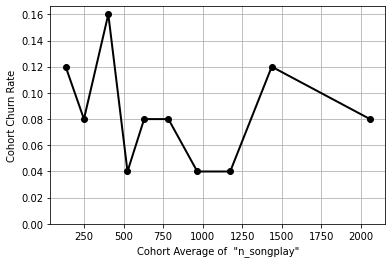

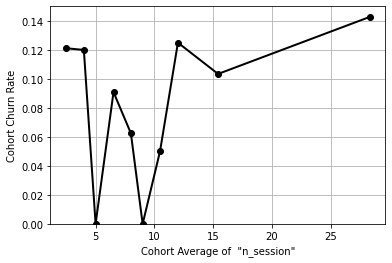

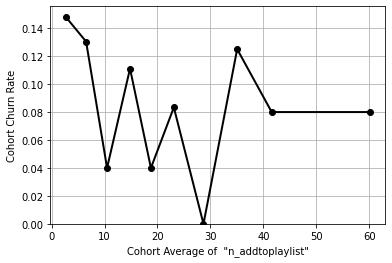

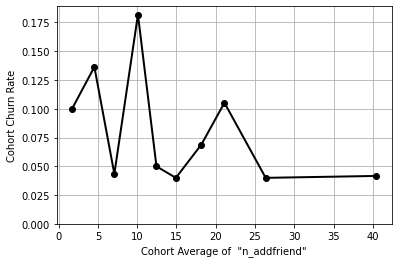

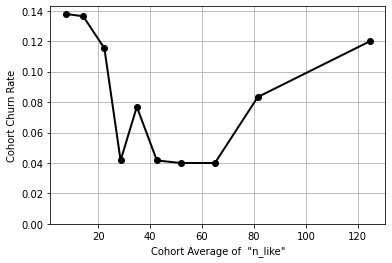

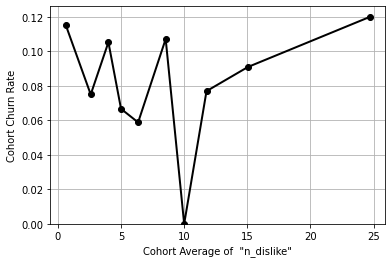

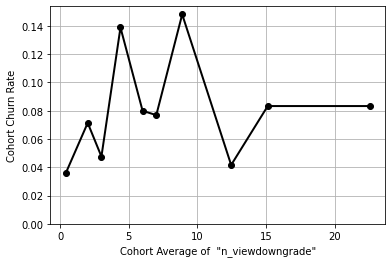

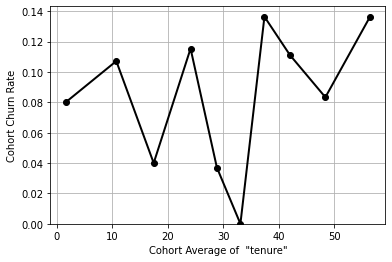

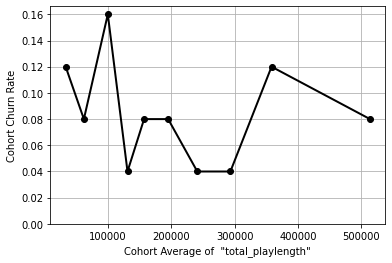

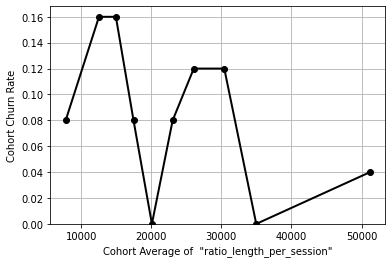

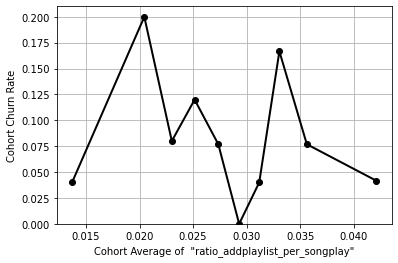

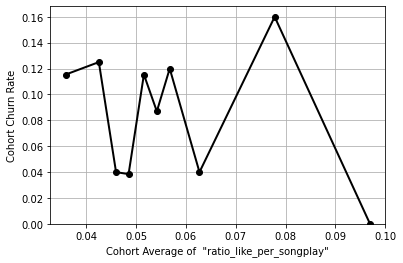

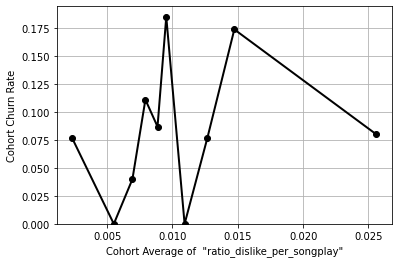

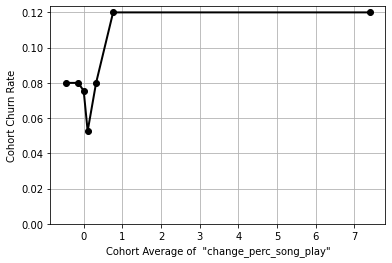

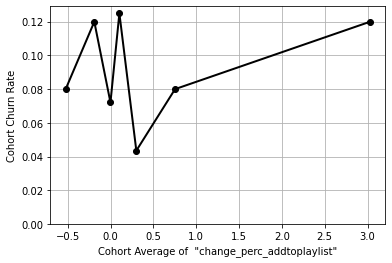

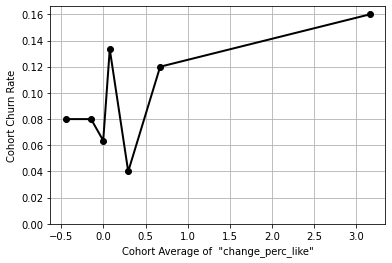

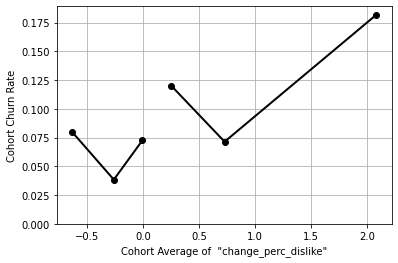

In [1905]:


for metric in dfana.columns[2:-1]:
    cohort_plot(metric, ncohort=10, df_data=dfana)


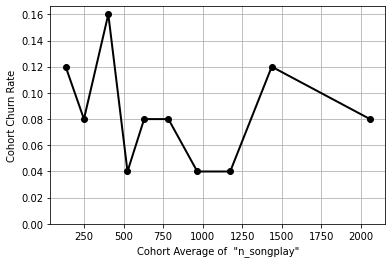

In [1843]:
cohort_plot('n_songplay')

In [1904]:
# Normalization / Standardization

data_scores = dfana.copy()
data_scores = data_scores.drop(['is_churn', 'observation_time', 'userId'], axis=1)

# mostly right skew which means most data less than mean value. data groups more before the mean. 
# long right tail shape


from sklearn import preprocessing

x = data_scores.values
x

min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x)
x_scaled

df_normalized = pd.DataFrame(x_scaled)
df_normalized.columns = data_scores.columns

df_normalized['is_churn'] = dfana.copy()['is_churn'].values
df_normalized

,n_songplay,n_session,n_addtoplaylist,n_addfriend,n_like,n_dislike,n_viewdowngrade,tenure,total_playlength,ratio_length_per_session,ratio_addplaylist_per_songplay,ratio_like_per_songplay,ratio_dislike_per_songplay,change_perc_song_play,change_perc_addtoplaylist,change_perc_like,change_perc_dislike,is_churn
0,0.039776,0.057692,0.017699,0.073171,0.013514,0.000000,0.040816,0.500000,0.038090,0.053219,0.210016,0.000000,0.000000,0.007353,0.072286,0.030841,0.20000,0
1,0.107563,0.096154,0.070796,0.158537,0.049550,0.062500,0.142857,0.733333,0.106683,0.114680,0.326333,0.042281,0.158664,0.021280,0.325299,0.102630,0.60000,0
2,0.233613,0.173077,0.185841,0.182927,0.148649,0.270833,0.163265,0.200000,0.231828,0.154559,0.400646,0.139626,0.321503,0.007353,0.072286,0.030841,0.20000,0
3,0.398319,0.153846,0.318584,0.414634,0.292793,0.333333,0.326531,0.433333,0.394973,0.314584,0.405493,0.196657,0.233820,0.013512,0.132528,0.064625,0.24616,0
4,0.328011,0.192308,0.336283,0.378049,0.270270,0.270833,0.265306,0.666667,0.323939,0.202658,0.518578,0.251721,0.229645,0.005802,0.076975,0.028120,0.16250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.042857,0.134615,0.044248,0.036585,0.040541,0.041667,0.000000,0.833333,0.043711,0.018531,0.489499,0.340216,0.252610,0.011784,0.198792,0.046225,0.13334,0
246,0.208403,0.230769,0.212389,0.121951,0.301802,0.208333,0.142857,0.000000,0.209004,0.099116,0.512116,0.628319,0.275574,0.008201,0.084338,0.030841,0.25000,0
247,0.228291,0.153846,0.256637,0.158537,0.418919,0.125000,0.102041,0.400000,0.227765,0.171249,0.567044,0.862340,0.152401,0.007353,0.072286,0.030841,0.20000,0
248,0.105882,0.115385,0.097345,0.036585,0.207207,0.083333,0.040816,0.633333,0.103940,0.091416,0.455574,0.929204,0.215031,0.002670,0.019937,0.012893,0.13334,0


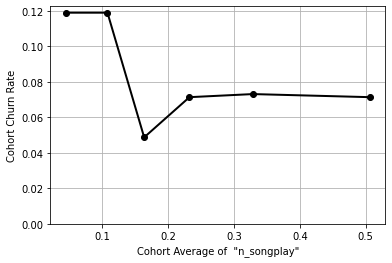

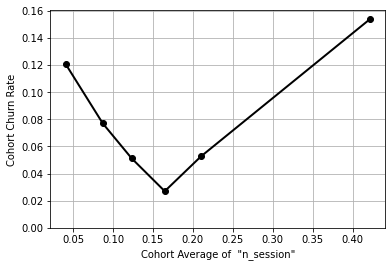

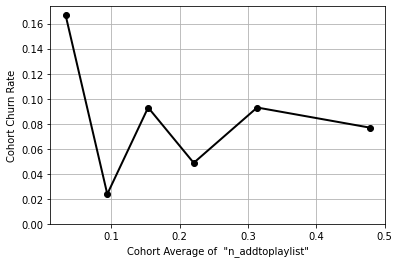

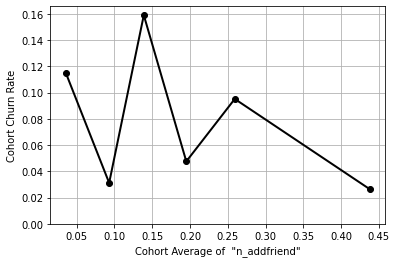

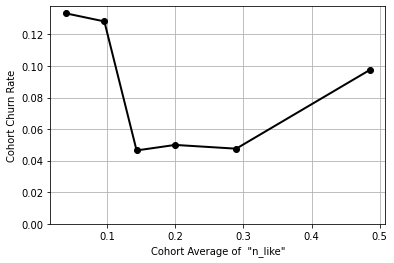

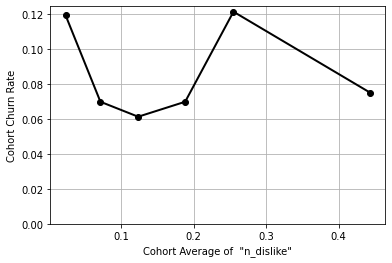

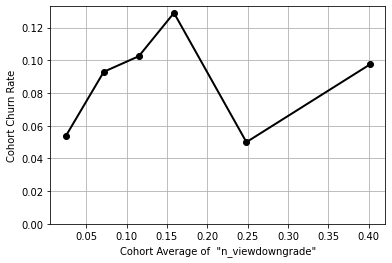

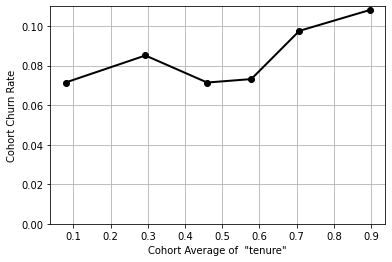

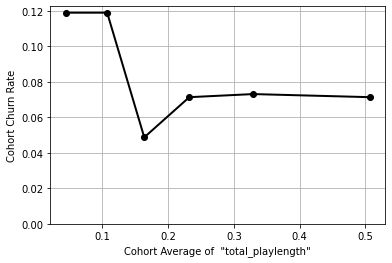

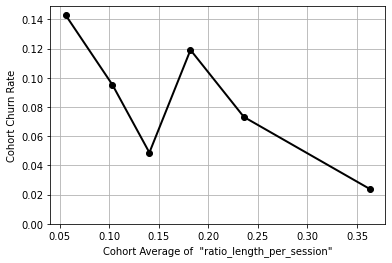

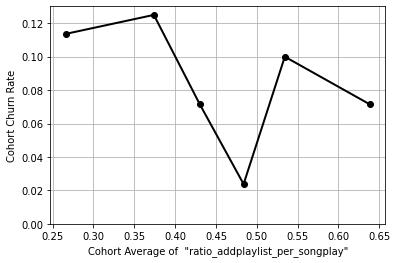

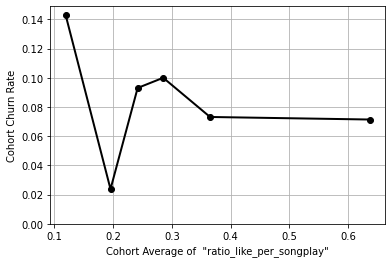

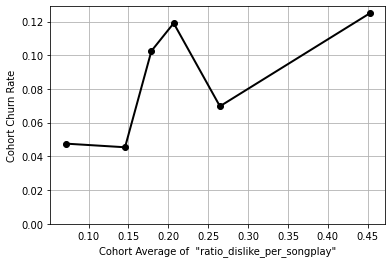

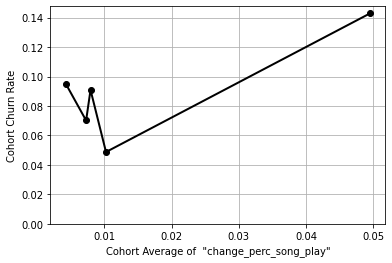

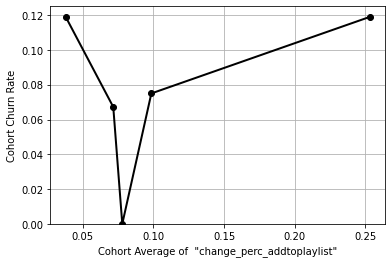

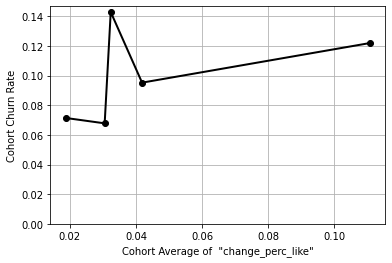

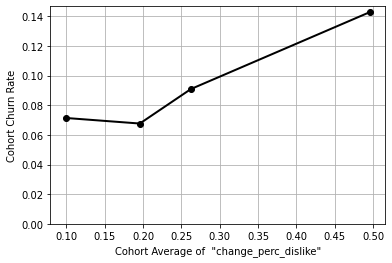

In [1901]:
for metric in df_normalized.columns[:-1]:
    cohort_plot(metric, ncohort=6, df_data=df_normalized)
